#IMPORT NECESSARY LIBRARIES

In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time


In [2]:
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG19, ResNet50V2, InceptionV3, Xception
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout

In [3]:
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

#DATA PREPARATION

##Define runtime

In [4]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
time: 421 µs (started: 2024-07-15 14:50:39 +00:00)


##Load Dataset

In [5]:
!gdown "1fHPO2Q9PyMHjDcyeAhjuuv8IjJ9OWoVd"

Downloading...
From (original): https://drive.google.com/uc?id=1fHPO2Q9PyMHjDcyeAhjuuv8IjJ9OWoVd
From (redirected): https://drive.google.com/uc?id=1fHPO2Q9PyMHjDcyeAhjuuv8IjJ9OWoVd&confirm=t&uuid=214afb74-8daa-442f-a6a7-6a71e612d04f
To: /content/HAM10000.zip
100% 5.58G/5.58G [01:31<00:00, 61.2MB/s]
time: 1min 36s (started: 2024-07-15 14:50:39 +00:00)


In [6]:
!unzip HAM10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: h

##Visualize data

###Support functions

In [7]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

time: 4.92 ms (started: 2024-07-15 14:53:53 +00:00)


In [8]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna(axis='columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


time: 826 µs (started: 2024-07-15 14:53:53 +00:00)


In [9]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    df = df.dropna(axis='columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


time: 810 µs (started: 2024-07-15 14:53:53 +00:00)


###Ploting data

In [10]:
nRowsRead = 100 # specify 'None' if want to read whole file
# HAM10000_metadata.csv has 10015 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/HAM10000_metadata.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'HAM10000_metadata.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 100 rows and 7 columns
time: 36 ms (started: 2024-07-15 14:53:53 +00:00)


In [11]:
df1.head(5)

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

time: 60 ms (started: 2024-07-15 14:53:53 +00:00)


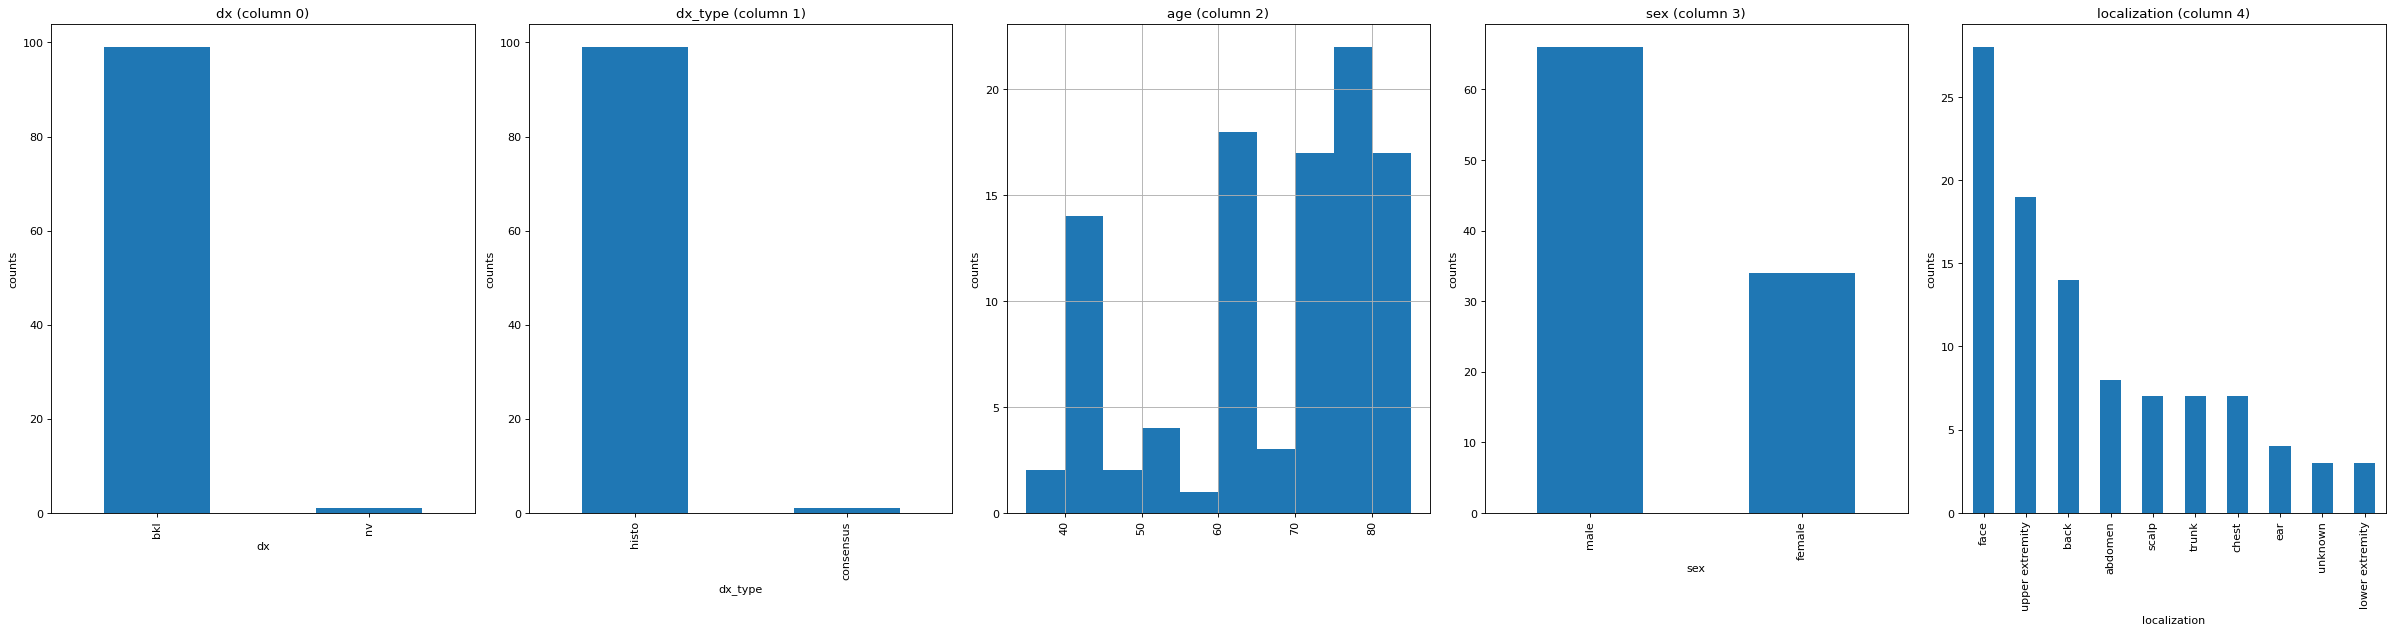

time: 1.22 s (started: 2024-07-15 14:53:53 +00:00)


In [12]:
plotPerColumnDistribution(df1, 10, 5)

In [13]:
nRowsRead = 100 # specify 'None' if want to read whole file
# hmnist_28_28_L.csv has 10015 rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('/content/hmnist_28_28_L.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'hmnist_28_28_L.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 100 rows and 785 columns
time: 41 ms (started: 2024-07-15 14:53:54 +00:00)


In [14]:
df2.head(5)

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        169        171        170        177        181        182   
1         19         57        105        140        149        148   
2        155        163        161        167        167        172   
3         25         71        116        139        136        153   
4        129        162        181        196        205        208   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0775  pixel0776  \
0        181        185        194        192  ...        184        186   
1        144        155        170        170  ...        172        175   
2        155        152        165        175  ...        163        178   
3        148        161        172        162  ...        125        135   
4        205        213        225        224  ...        210        197   

   pixel0777  pixel0778  pixel0779  pixel0780  pixel0781  pixel0782  \
0        185        180        157        140        140        159   
1        160        144        114         89         47         18   
2        157        166        167        148        141        136   
3        138        137        111         71         32         16   
4        172        190        195        193        181        147   

   pixel0783  label  
0        165      2  
1         18      2  
2        115      2  
3         16      2  
4         88      2  

[5 rows x 785 columns]

time: 15.1 ms (started: 2024-07-15 14:53:54 +00:00)


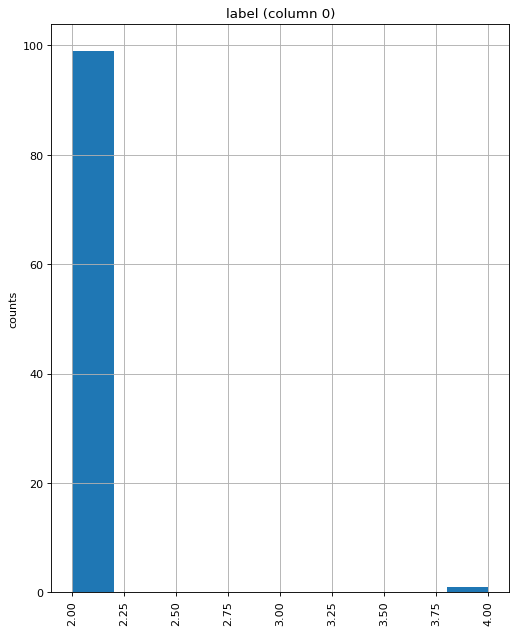

time: 397 ms (started: 2024-07-15 14:53:54 +00:00)


In [15]:
plotPerColumnDistribution(df2, 10, 5)

In [ ]:
plotCorrelationMatrix(df2, 196)

time: 1min 5s (started: 2024-07-14 17:44:23 +00:00)


In [ ]:
plotScatterMatrix(df2, 20, 10)

In [16]:
nRowsRead = 10 # specify 'None' if want to read whole file
# hmnist_28_28_RGB.csv has 10015 rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('/content/hmnist_28_28_RGB.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'hmnist_28_28_RGB.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 10 rows and 2353 columns
time: 81.9 ms (started: 2024-07-15 14:56:48 +00:00)


In [17]:
df3.head(5)

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

time: 24.6 ms (started: 2024-07-15 14:56:50 +00:00)


In [18]:
plotPerColumnDistribution(df3, 10, 5)

ValueError: Image size of 2400x301440 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x7a3ea1797eb0> (for post_execute):


ValueError: Image size of 2400x301440 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 2400x301440 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2400x301440 with 10 Axes>

time: 1.79 s (started: 2024-07-15 14:56:53 +00:00)


In [ ]:
plotCorrelationMatrix(df3, 588)

In [ ]:
plotScatterMatrix(df3, 20, 10)

#MODEL IMPLEMENTATION

##Models Initialization

###Load pre-trained models

In [ ]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
resnet50v2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(240, 426, 3))
xception = Xception(weights='imagenet', include_top=False, input_shape=(240, 426, 3))

83683744/83683744 [==============================] - 0s 0us/step
time: 10.8 s (started: 2024-04-07 16:16:34 +00:00)


###Define a custom CNN autoencoder model

In [ ]:
from tensorflow.keras import regularizers
def custom_cnn_model():
    # Define the Convolutional Autoencoder architecture

    input_img = Input(shape=(240, 426, 3))

    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='Encoding_Conv2D_1')(input_img)
    x = MaxPooling2D((2, 2), padding='same', name='Encoding_MaxPooling2D_1')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='Encoding_Conv2D_2')(x)
    x = MaxPooling2D((2, 2), padding='same', name='Encoding_MaxPooling2D_2')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='Encoding_Conv2D_3')(x)
    x = MaxPooling2D((2, 2), padding='same', name='Encoding_MaxPooling2D_3')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), name='Encoding_Conv2D_4')(x)
    encoded = MaxPooling2D((2, 2), padding='valid', name='Encoding_MaxPooling2D_4')(x)

    # This is the encoded representation of the input
    autoencoder = Model(input_img, encoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

customCNN = custom_cnn_model()

time: 196 ms (started: 2024-04-07 16:26:21 +00:00)


In [ ]:
customCNN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 240, 426, 3)]     0         
                                                                 
 Encoding_Conv2D_1 (Conv2D)  (None, 240, 426, 64)      1792      
                                                                 
 Encoding_MaxPooling2D_1 (M  (None, 120, 213, 64)      0         
 axPooling2D)                                                    
                                                                 
 Encoding_Conv2D_2 (Conv2D)  (None, 120, 213, 128)     73856     
                                                                 
 Encoding_MaxPooling2D_2 (M  (None, 60, 107, 128)      0         
 axPooling2D)                                                    
                                                                 
 Encoding_Conv2D_3 (Conv2D)  (None, 60, 107, 256)      2951

## Set models' name

In [ ]:
vgg19_name = 'vgg19'
resnet50v2_name = 'resnet50'
inceptionv3_name = 'inceptionv3'
xception_name = 'xception'
customCNN_name = 'customCNN'

time: 683 µs (started: 2024-04-07 16:16:45 +00:00)


##Model works

In [ ]:
def extract_features(input_array, model_name):
    if model_name == vgg19_name:
        return vgg19.predict(input_array)

    elif model_name == resnet50v2_name:
        return resnet50v2.predict(input_array)

    elif model_name == inceptionv3_name:
        return inceptionv3.predict(input_array)

    elif model_name == xception_name:
        return xception.predict(input_array)

    elif model_name == customCNN_name:
        return customCNN.predict(input_array)

    else: return

time: 626 µs (started: 2024-04-07 16:16:45 +00:00)


#DEFINE FUNCTIONS

##Compute similarity

## Preprocessing


In [ ]:
def get_features_flatten(model_name,images):
  start_time = time.time()
  train_features = extract_features(images, model_name)
  end_time = time.time()
  print(f"Time taken for feature extraction: {end_time - start_time} seconds")
  print(f"Using {model_name}, we get {train_features.shape}")
  train_features_flat = train_features.reshape(train_features.shape[0], -1)
  return train_features_flat

time: 590 µs (started: 2024-04-07 16:17:19 +00:00)


In [ ]:
def preprocessing_input_image(input_image_path):
  img = cv2.imread(input_image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (426, 240))
  return img


time: 517 µs (started: 2024-04-07 16:17:19 +00:00)


##Visualization

In [ ]:
def visualize_the_images(input_image_path, similar_image_indexs, similarity_scores):
  original_image = preprocessing_input_image(input_image_path)
  plt.figure(figsize=(16, 8))
  # Plot original image
  plt.subplot(2, 6, 1)
  plt.imshow(original_image)
  plt.title(f'Original Image\n{input_image_path}')
  plt.axis('off')

  # Plot similar images
  for i, idx in enumerate(similar_image_indexs):
        similar_image = images[idx]
        plt.subplot(2, 6, i + 7)
        plt.imshow(similar_image)
        plt.title(f'Cosine similarity: {similarity_scores[i]["cossim"]*100:.2f}%\nStructural similarity: {similarity_scores[i]["ssim"]*100:.2f}%\nHistogram similarity: {similarity_scores[i]["hissim"]*100:.2f}%\n{similarity_scores[i]["filename"]}')
        plt.axis('off')

  plt.tight_layout()
  plt.show()




time: 873 µs (started: 2024-04-07 16:17:19 +00:00)


In [ ]:
def visualize_the_histogram(input_image_path, similar_image_indexs,similarity_scores):
  original_image = preprocessing_input_image(input_image_path)
  plt.figure(figsize=(45, 10))
  plt.subplot(2, 7, 1)
  plt.imshow(original_image)
  plt.title(f'Original Image\n{input_image_path}')
  plt.axis('off')
  plt.subplot(2, 7, 8)
  for i, color in enumerate(['r', 'g', 'b']):
        hist = cv2.calcHist([original_image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
  plt.title('Original Image RGB Histogram')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Frequency')


  for i, idx in enumerate(similar_image_indexs):
    plt.subplot(2, 7,i+2)
    plt.title(f'Cosine similarity: {similarity_scores[i]["cossim"]*100:.2f}%\nStructural similarity: {similarity_scores[i]["ssim"]*100:.2f}%\nHistogram similarity: {similarity_scores[i]["hissim"]*100:.2f}%\n{similarity_scores[i]["filename"]}')
    plt.imshow(images[idx])
    plt.axis('off')
    plt.subplot(2, 7, i+9)
    plt.title(f'Similar Image {i} Histogram')
    for i, color in enumerate(['r', 'g', 'b']):
        hist = cv2.calcHist([images[idx]], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
  ######## TO DO ADD Ve histogram rieng
  plt.show()

time: 1.72 ms (started: 2024-04-07 16:17:19 +00:00)


In [ ]:
def highlight_features(image1, image2):
    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)

    # Create a BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match the descriptors
    matches = bf.match(des1, des2)

    # Sort the matches based on distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw the first 50 matches
    result = cv2.drawMatches(image1, kp1, image2, kp2, matches[:50], None, flags=2)

    return result

time: 719 µs (started: 2024-04-07 16:17:19 +00:00)


In [ ]:
def visualize_highlight(input_image_path, similar_image_indexs, similarity_scores):
  original_image = preprocessing_input_image(input_image_path)
  plt.figure(figsize=(25, 5))
  # Plot original image
  plt.subplot(2, 6, 1)
  plt.imshow(original_image)
  plt.title(f'Original Image\n{input_image_path}')
  plt.axis('off')

  # Plot similar images
  for i, idx in enumerate(similar_image_indexs):
        similar_image = images[idx]
        highlighted_image = highlight_features(original_image, similar_image)
        plt.subplot(2, 6, i + 7)
        plt.imshow(highlighted_image)
        plt.title(f'Cosine similarity: {similarity_scores[i]["cossim"]*100:.2f}%\nStructural similarity: {similarity_scores[i]["ssim"]*100:.2f}%\nHistogram similarity: {similarity_scores[i]["hissim"]*100:.2f}%\n{similarity_scores[i]["filename"]}')
        plt.axis('off')

  plt.tight_layout()
  plt.show()

time: 992 µs (started: 2024-04-07 16:17:19 +00:00)


##Input image

In [ ]:
def image_similarity(input_image_path,model_name,all_features, n_neighbors):
  input_image = preprocessing_input_image(input_image_path)

  input_image = np.expand_dims(input_image, axis=0)
  input_features = extract_features(input_image, model_name)
  input_features_flat = input_features.reshape(input_features.shape[0], -1)
  # Train a k-NN model
  knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
  knn.fit(all_features)

  start_time = time.time()

  distances, indices = knn.kneighbors(input_features_flat, n_neighbors=6)
  end_time = time.time()

  time_taken = end_time - start_time
  print(f"Time taken for prediction: {time_taken} seconds")
  #silhouette = silhouette_score(all_features, input_features_flat)
  #davies_bouldin = davies_bouldin_score(all_features, input_features_flat)
  #calinski_harabasz = calinski_harabasz_score(all_features, input_features_flat)

  #print(f"Silhouette Score: {silhouette}")
  #print(f"Davies-Bouldin Index: {davies_bouldin}")
  #print(f"Calinski-Harabasz Index: {calinski_harabasz}")
  return indices[0]


time: 787 µs (started: 2024-04-07 16:17:19 +00:00)


#TESING MODELS

##Feature extraction

In [ ]:
import pickle
def store_features(input_array):
    model_names = ['vgg19','resnet50','inceptionv3','xception','customCNN']
    features_dict = {}

    for model_name in model_names:
        features = get_features_flatten( model_name,input_array)
        if features is not None:
            with open(f"/content/drive/MyDrive/Pickle/{model_name}_all_features.pkl", 'wb') as f:
                pickle.dump(features, f)

store_features(images)

38/38 [==============================] - 11s 296ms/step
Time taken for feature extraction: 21.307188987731934 seconds
Using vgg19, we get (1209, 7, 13, 512)
38/38 [==============================] - 6s 154ms/step
Time taken for feature extraction: 11.092413902282715 seconds
Using resnet50, we get (1209, 8, 14, 2048)
38/38 [==============================] - 4s 112ms/step
Time taken for feature extraction: 6.2546234130859375 seconds
Using inceptionv3, we get (1209, 6, 11, 2048)
38/38 [==============================] - 9s 236ms/step
Time taken for feature extraction: 21.35185742378235 seconds
Using xception, we get (1209, 8, 14, 2048)
38/38 [==============================] - 6s 104ms/step
Time taken for feature extraction: 11.286916494369507 seconds
Using customCNN, we get (1209, 15, 27, 512)
time: 1min 41s (started: 2024-04-07 16:26:43 +00:00)


In [ ]:
model_name = customCNN_name
number_neighbors = 9

features = get_features_flatten(model_name,images)


## wait for gpu

38/38 [==============================] - 9s 135ms/step
Time taken for feature extraction: 22.59525775909424 seconds
Using customCNN, we get (1209, 240, 432, 3)
time: 22.6 s (started: 2024-04-05 16:12:22 +00:00)


##Get test images

In [ ]:
!gdown "1Aol-xFrXTZ0SlF4nFwsyWqHdhaHKdEqn"
!unzip test_data.zip
# Get all image file paths
test_dir = "/content/test_data"
all_images_test = [os.path.join(data_ws_dir, filename) for filename in os.listdir(data_ws_dir)]
test_images = []
for img_path in all_images_test:
        test_img = cv2.imread(img_path)
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        test_images.append(test_img)
test_images = np.array(test_images)


##Test the model